In [1]:
## Example month mean notebook CPOL

In [1]:
from dask_jobqueue import SLURMCluster
import dask.array as da
from dask import delayed
import pyart
import glob
from distributed import Client
%pylab inline
import pandas as pd
import dask.bag as db
import dask.array as da
from dask import delayed
from datetime import timedelta
import xarray as xr


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/rjackson/.local/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/rjackson/.local/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def get_rainfall_rate(filename, level=3):
    grid = pyart.io.read_grid(filename, include_fields="radar_estimated_rain_rate")
    rr = grid.fields["radar_estimated_rain_rate"]["data"][level]
    del grid
    return rr.filled(0)

def get_mean_rr_rate_in_box(filename, level=3):
    grid = pyart.io.read_grid(filename, include_fields="radar_estimated_rain_rate")
    rr = grid.fields["radar_estimated_rain_rate"]["data"][level].filled(np.nan)
    x = grid.point_x["data"][level]
    y = grid.point_y["data"][level]
    # X range of box 1 -105000.0 47500.0
    # Y range of box 1 -122500.0 32500.0
    our_box = np.logical_and.reduce((x >= -105000., x <= 47500.0, y >= -122500., y <= 32500.))
    return np.nanmean(rr[our_box])

def get_file_time(filename):
    our_parts = filename.split("/")
    return datetime.datetime.strptime(our_parts[-1], "twp10cpolgrid150.b2.%Y%m%d.%H%M%S.nc")



In [3]:
list_of_files = glob.glob('/lcrc/group/earthscience/rjackson/CPOL/grid_150km_2500m/**/*.nc', recursive=True)
list_of_files = sorted(list_of_files)
file_times = np.array([get_file_time(x) for x in list_of_files])

In [4]:
cluster = SLURMCluster(time='1:00:00', processes=6, cores=36, memory='128 GB', project='rainfall')
cluster.scale(6)

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/tornado/concurrent.py:521: DeprecationWarning: @return_future is deprecated, use coroutines instead
  DeprecationWarning)


In [5]:
client = Client(cluster)

In [11]:
client

Client Scheduler: tcp://140.221.70.5:40261 Dashboard: http://140.221.70.5:36695/status,Cluster Workers: 6 Cores: 36 Memory: 127.98 GB


In [157]:
cluster.scale(6)

In [14]:
file_times

array([datetime.datetime(1998, 12, 6, 6, 30),
       datetime.datetime(1998, 12, 6, 6, 40),
       datetime.datetime(1998, 12, 6, 6, 50), ...,
       datetime.datetime(2017, 5, 2, 0, 40),
       datetime.datetime(2017, 5, 2, 0, 50),
       datetime.datetime(2017, 5, 2, 1, 0)], dtype=object)

In [18]:
cluster.stop_all_jobs()

In [13]:
grid1 = pyart.io.read_grid(list_of_files[0])
x = grid1.point_x["data"][1]
y = grid1.point_y["data"][1]
rr = grid1.fields["radar_estimated_rain_rate"]["data"][1]
z = grid1.z["data"]
grid_lat = grid1.point_latitude["data"]
grid_lon = grid1.point_longitude["data"]

In [11]:
rr_rate = delayed(get_rainfall_rate)
rrs = [da.from_delayed(rr_rate(x), shape=rr.shape, dtype=float) for x in list_of_files[:300]]
rrs = da.stack(rrs)
rrs = da.nanmean(rrs, axis=0)

In [12]:
%time rrate = rrs.compute()

CPU times: user 3.56 s, sys: 330 ms, total: 3.89 s
Wall time: 40.4 s


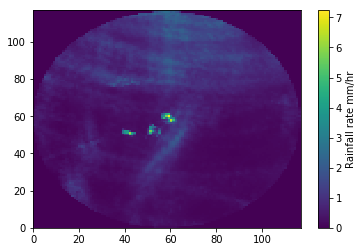

In [17]:
plt.pcolormesh(rrate)
plt.colorbar(label = "Rainfall rate mm/hr")

In [ ]:
rr_rate = delayed(get_rainfall_rate)
rrs = [da.from_delayed(rr_rate(x), shape=rr.shape, dtype=float) for x in list_of_files[:1100]]
rrs = da.stack(rrs)
%time rrs = rrs.compute()

In [ ]:
plt.figure(figsize=(15,6))
plt.scatter(file_times[:1100], rrs[:1100, 80, 80])
plt.xlim([file_times[0], file_times[600]])
plt.xlabel("Time")
plt.ylabel("Rainfall rate")